## Survival Analysis

The goal of this section is to estimate "time until next sale" based on historical date on a per product basis. Given the fact that our dataset contains information about reviews rather than purchases, we will substitute with predicting "time until next review". Naturally a review on a products appears sometime after the purchase and review distributions can therefore also be assumed to somewhat correlate with purchase distributions. Additionally, when implementing the idea in practice, a given company would likely have access to the raw purchase data and adapting to process to suit said data would be straightforward.

In [1]:
# https://allendowney.github.io/SurvivalAnalysisPython/02_kaplan_meier.html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
df = pd.read_csv('merged_df.csv')
df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)

In [3]:
df['date'] = pd.to_datetime(df['unixReviewTime'], unit='s')

In [4]:
df = df[['asin', 'reviewerID', 'date', 'overall']].sort_values(by='date')
df['prev_review_delta'] = df.groupby('asin')['date'].diff().dt.days
df.dropna(subset=['prev_review_delta'], inplace=True)

In [5]:
def plot_lifelines(obs):
    """Plot a line for each observation.
    
    obs: DataFrame
    """
    obs.sort_values(by='date', inplace=True)
    obs = obs.reset_index(drop=True)
    cmap = matplotlib.cm.get_cmap('Set1')
    for i, asin in enumerate(obs.asin.unique()):
        start = 0
        for j, (y, row) in enumerate(obs[obs.asin == asin].iterrows()):
    #         start = row['start']
    #         end = row['end']
    #         status = row['status']

    #         if status == 0:
    #             # ongoing
    #             plt.hlines(y, start, end, color='C0')
    #         else:
                # complete
            delay = row['prev_review_delta']
            color = cmap(i)
            plt.hlines(y, start, start+delay, color=color)
            plt.plot(start+delay, y, marker='o', color=color)
            start += delay
            
    plt.xlabel('Time (weeks)')
    plt.ylabel('Dog index')
    plt.gca().invert_yaxis()

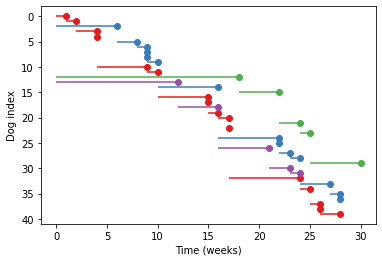

In [6]:
asins = ['B000KJVIOI', 'B000LKV7LU', 'B000G8399A', 'B000KA9I6W']
df[df.asin.isin(asins)][-50:]
plot_lifelines(df[df.asin.isin(asins)][-40:])

In [79]:
# How many purchases are made per product at time t
events = df.groupby(['asin', 'prev_review_delta'])['date'].count().rename('event_count').rename('events')
# How many purchase executions are "avialable" at time just before t
num_subjects = (events.sort_index(ascending=False)
                .groupby('asin')
                .cumsum()
                .sort_index(ascending=True)
                .rename('num_subjects'))
# Hazard rate per time t
hazard = (events / num_subjects).rename('hazard')
# Survival rate per time t
survival = (1 - hazard).groupby('asin').cumprod().rename('survival')
# cdf per time t
cdf = (1 - survival).round(5).rename('cdf')
# Change in cdf per time t
pmf = cdf.groupby('asin').diff().fillna(0).abs().rename('pmf')
info = pd.concat([events, num_subjects, hazard, survival, cdf, pmf], axis=1)
info

events  num_subjects    hazard  survival  \
asin       prev_review_delta                                             
4639725043 1.0                     1            27  0.037037  0.962963   
           2.0                     1            26  0.038462  0.925926   
           5.0                     1            25  0.040000  0.888889   
           8.0                     1            24  0.041667  0.851852   
           9.0                     1            23  0.043478  0.814815   
...                              ...           ...       ...       ...   
B000PGHLNS 60.0                    1             5  0.200000  0.285714   
           63.0                    1             4  0.250000  0.214286   
           75.0                    1             3  0.333333  0.142857   
           100.0                   1             2  0.500000  0.071429   
           2376.0                  1             1  1.000000  0.000000   

                                  cdf      pmf  
asin       prev_review_delta                    
4639725043 1.0                0.03704  0.00000  
           2.0                0.07407  0.03703  
           5.0                0.11111  0.03704  
           8.0                0.14815  0.03704  
           9.0                0.18519  0.03704  
...                               ...      ...  
B000PGHLNS 60.0               0.71429  0.07143  
           63.0               0.78571  0.07142  
           75.0               0.85714  0.07143  
           100.0              0.92857  0.07143  
           2376.0             1.00000  0.07143  

[64122 rows x 6 columns]

The code above uses the Kaplan-Meier estimator to assess the survival function directly from the review data. The resulting dataframe functions as a lookup table for each product (asin), where for each seen "time since last review" the survival rate among other values is readily available.

For example; asin: 'B0001LO3FG' is one of the most selling products in the dataset. At time t=5, it has been 5 days since the last review of the product and the company would like to know a few things:
* How likely are they to receive the next review today (at t=5)? - Hazard rate
* How often will they have to wait until atleast day 5 for a review? - Survival rate
* 

In [87]:
print(info.loc['B0001LO3FG', 5], "\n")
print("Question: How likely are they to receive the next review today (at t=5)? - Hazard rate")

print("Answer: They will have to wait")

events           33.000000
num_subjects    172.000000
hazard            0.191860
survival          0.047635
cdf               0.952360
pmf               0.011300
Name: (B0001LO3FG, 5.0), dtype: float64 

Question: How likely are they to receive the next review today (at t=5)? - Hazard rate
Answer: They will have to wait


In [78]:
info.loc['B0001LO3FG']

,events,num_subjects,hazard,survival,cdf,pmf
prev_review_delta,,,,,,
0.0,1296,2918,0.444140,0.555860,0.44414,0.00000
1.0,1011,1622,0.623305,0.209390,0.79061,0.34647
2.0,307,611,0.502455,0.104181,0.89582,0.10521
3.0,86,304,0.282895,0.074709,0.92529,0.02947
4.0,46,218,0.211009,0.058944,0.94106,0.01577
5.0,33,172,0.191860,0.047635,0.95236,0.01130
6.0,23,139,0.165468,0.039753,0.96025,0.00789
7.0,16,116,0.137931,0.034270,0.96573,0.00548
8.0,12,100,0.120000,0.030158,0.96984,0.00411


In [69]:
info.loc['B000P6J1M2', 13]

events          1.000000
num_subjects    7.000000
hazard          0.142857
survival        0.315789
cdf             0.684210
pmf             0.052630
Name: (B000P6J1M2, 13.0), dtype: float64